# RFM Analysis and Customer Segmentation
## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE



## Loading Data

In [92]:
transactions = pd.read_csv('data/transactions.csv')
customers = pd.read_csv('data/customers.csv')
campaign = pd.read_csv('data/campaign.csv')

# Preview the data
print("Transactions Data:")
print(transactions.head())
print("\nCustomers Data:")
print(customers.head())
print("\nCampaign Data:")
print(campaign.head())



Transactions Data:
        CardID      Date  Amount
0  C0100000199  20010820  229.00
1  C0100000199  20010628  139.00
2  C0100000199  20011229  229.00
3  C0100000343  20010727   49.00
4  C0100000343  20010202  169.99

Customers Data:
        CardID MaritalStatus  NumChildren       LoS   HHIncomeMed
0  C0100000199             S            4  1.156164  71079.744865
1  C0100000343           NaN            1  3.002740  79424.115726
2  C0100000375             S            0  0.068493  41878.414258
3  C0100000482             S            1  1.356164  62924.588763
4  C0100000689             M            3  2.484932  46616.718039

Campaign Data:
        CardID Responded
0  C0100000199         F
1  C0100000343         F
2  C0100000375         F
3  C0100000482         F
4  C0100000689         F


## Calculating RFM

In [93]:
# RFM Calculation
print("\nCalculating RFM Values...")

# 1. Recency (Days since last purchase)
transactions['Date'] = pd.to_datetime(transactions['Date'].astype(str), format='%Y%m%d')
latest_date = transactions['Date'].max()
transactions['Recency'] = (pd.to_datetime(latest_date) - pd.to_datetime(transactions['Date'])).dt.days
recency_df = transactions.groupby('CardID')['Recency'].min().reset_index()

# 2. Frequency (Number of purchases)
frequency_df = transactions.groupby('CardID')['Date'].count().reset_index()
frequency_df.columns = ['CardID', 'Frequency']

# 3. Monetary (Total amount spent)
monetary_df = transactions.groupby('CardID')['Amount'].sum().reset_index()
monetary_df.columns = ['CardID', 'Monetary']

# Merge RFM data
rfm = recency_df.merge(frequency_df, on='CardID').merge(monetary_df, on='CardID')

print("\nRFM Data:")
print(rfm.head())




Calculating RFM Values...

RFM Data:
        CardID  Recency  Frequency  Monetary
0  C0100000199        1          3    597.00
1  C0100000343      114          6    700.94
2  C0100000375       59          4    223.98
3  C0100000482       20          4    197.98
4  C0100000689        4          2    428.00


In [94]:
rfm = rfm # Replace with your actual file path

# Scoring RFM values based on quintiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combine RFM scores into a single segment code
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Assigning customer segments based on RFM segments
def assign_segment(row):
    if row['RFM_Segment'] == '555':
        return 'Soulmates'
    elif row['R_Score'] == 1 and row['F_Score'] == 5 and row['M_Score'] == 5:
        return 'Ex-Lovers'
    elif row['R_Score'] == 5 and row['F_Score'] == 1 and row['M_Score'] == 1:
        return 'Apprentice'
    elif row['F_Score'] >= 4 and row['M_Score'] >= 4 and row['R_Score'] >= 4:
        return 'Lovers'
    else:
        return 'Other'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

# Display the processed RFM table
rfm_display = rfm[['CardID', 'R_Score', 'F_Score', 'M_Score', 'RFM_Segment', 'Segment']]
rfm_display.to_csv("processed_rfm_table.csv", index=False)  # Save the table as a CSV file
rfm_display.head()  # Display the first few rows in the notebook


,CardID,R_Score,F_Score,M_Score,RFM_Segment,Segment
0,C0100000199,5,2,4,524,Other
1,C0100000343,2,5,5,255,Other
2,C0100000375,3,3,2,332,Other
3,C0100000482,4,3,2,432,Other
4,C0100000689,5,1,4,514,Other


In [95]:
# Normalize RFM values
scaler = StandardScaler()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']]), columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled['CardID'] = rfm['CardID']
print(rfm_scaled.head())

# RFM Segmentation
print("\nSegmenting Customers...")
for i in range(6):
    kmeans = KMeans(n_clusters=2 + i, random_state=42)
    rfm['RFM_Segment_' + str(i)] = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

# Merge with Socio-Demographic Data
full_data = rfm.merge(customers, on='CardID')

# Campaign Response Classification
print("\nClassifying Campaign Response...")
data_with_response = full_data.merge(campaign, on='CardID')
X = data_with_response[['Recency', 'Frequency', 'Monetary', 'HHIncomeMed', 'NumChildren', 'LoS']]
y = data_with_response['Responded']
y = y.map({'F': 0, 'T': 1})

    Recency  Frequency  Monetary       CardID
0 -1.029144  -0.375675  0.473691  C0100000199
1  0.365664   0.075486  0.766177  C0100000343
2 -0.313225  -0.225288 -0.575983  C0100000375
3 -0.794619  -0.225288 -0.649147  C0100000482
4 -0.992114  -0.526062 -0.001874  C0100000689

Segmenting Customers...

Classifying Campaign Response...



Visualizing Clusters...


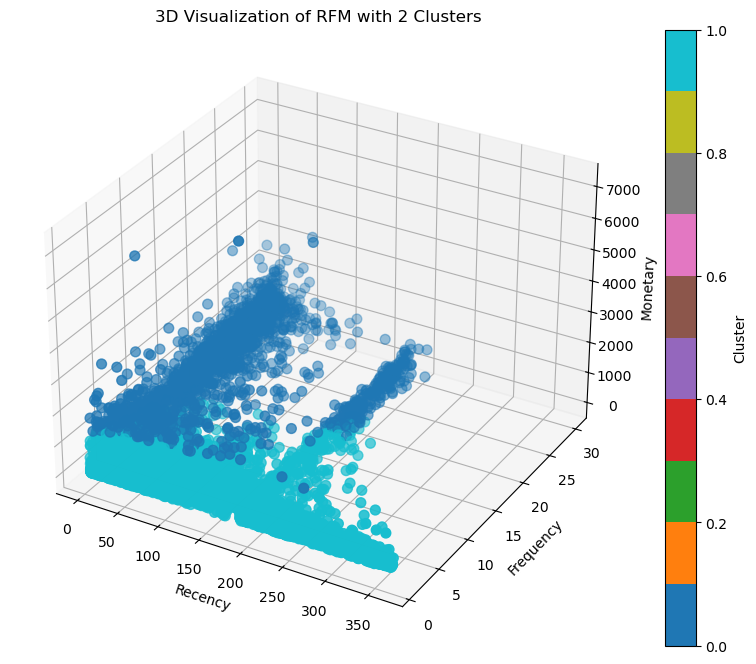

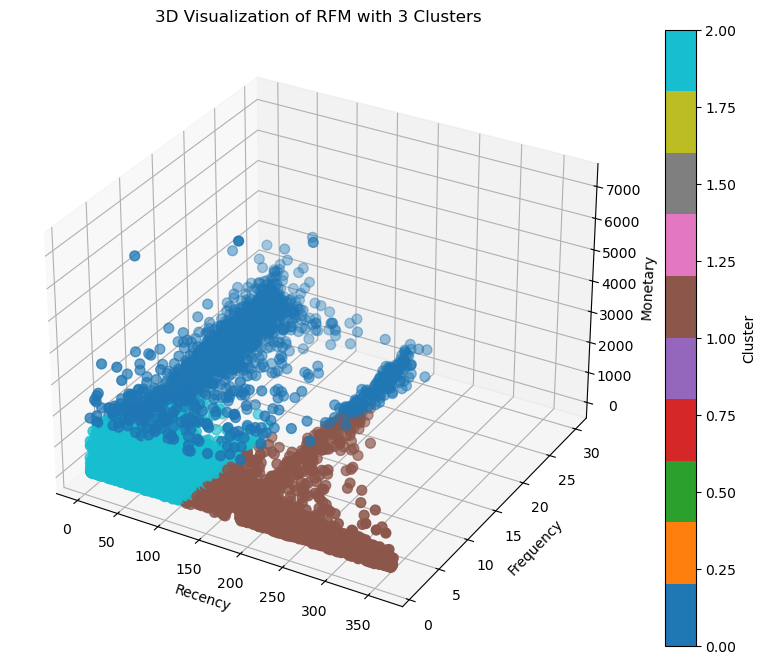

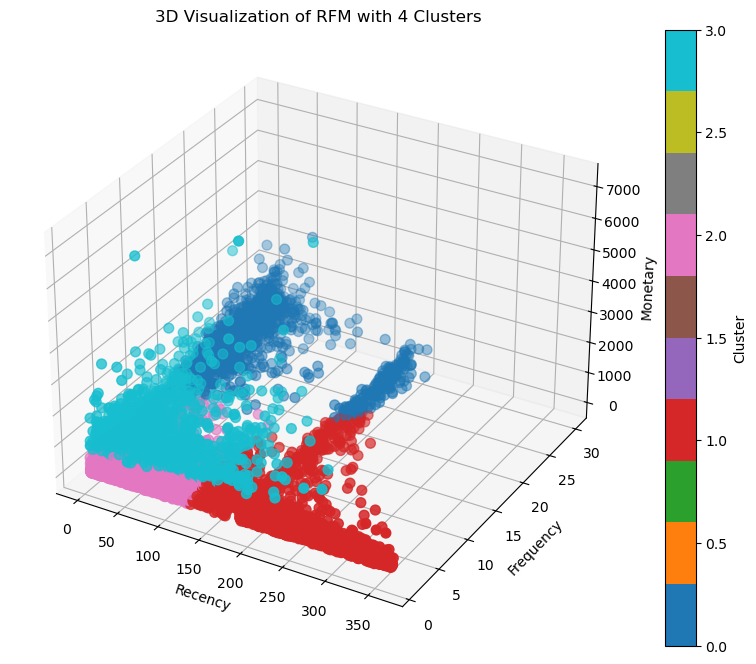

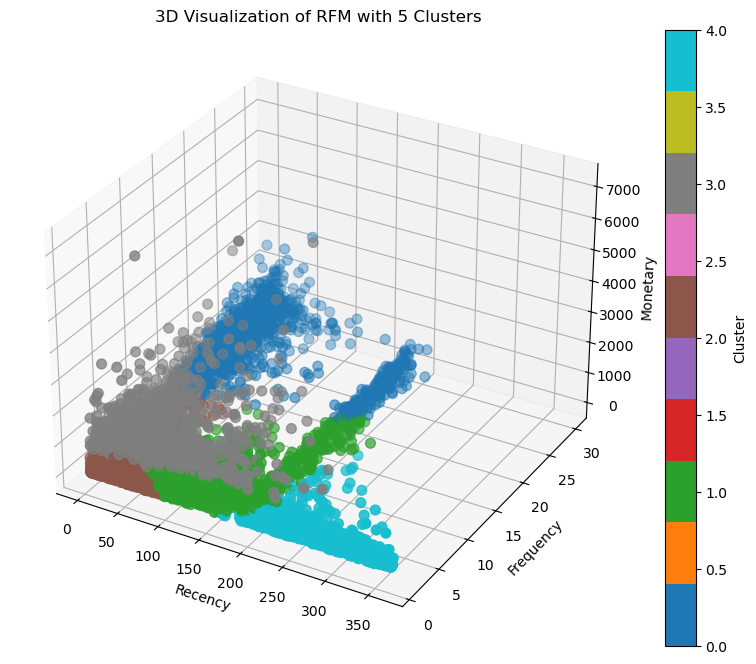

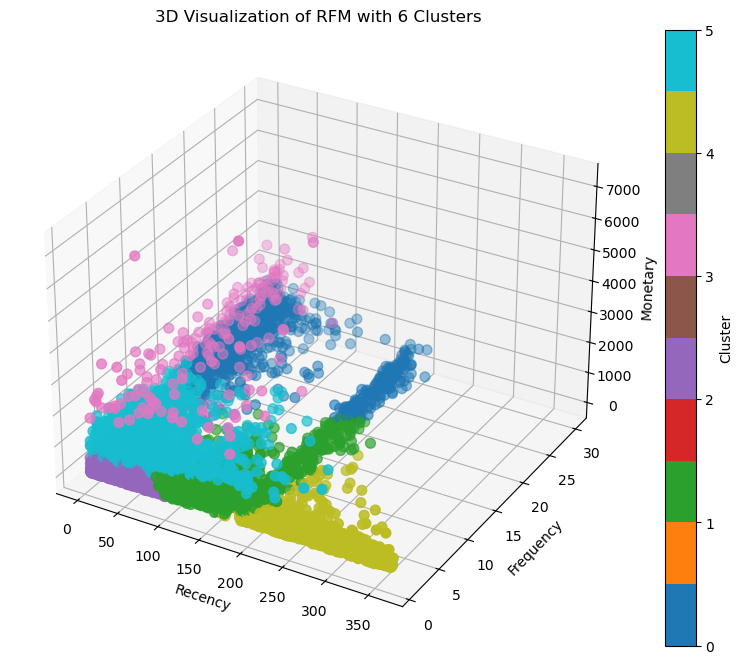

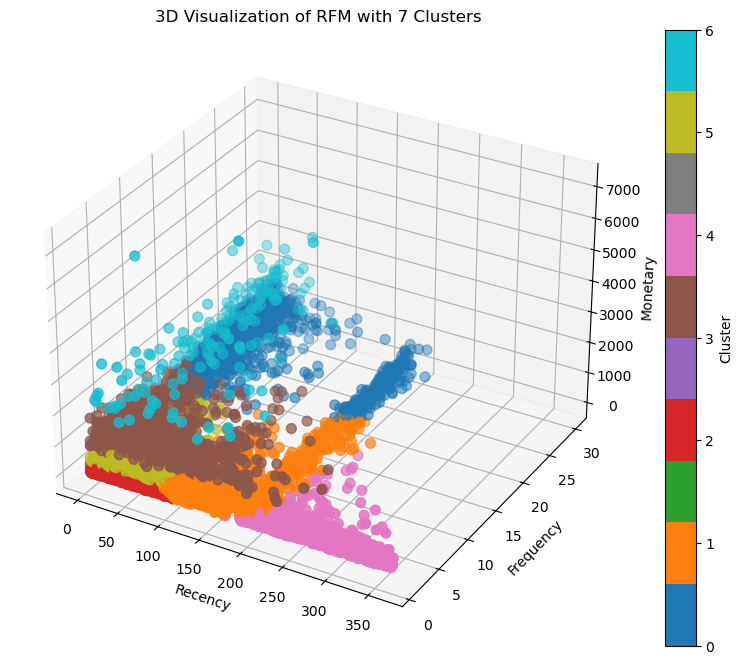

In [96]:
# Visualizing the Clusters from RFM Segmentation
print("\nVisualizing Clusters...")

# 3D Visualization of RFM Clusters
for i in range(6):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(
        rfm['Recency'],
        rfm['Frequency'],
        rfm['Monetary'],
        c=rfm['RFM_Segment_' + str(i)],
        cmap='tab10',
        s=50
    )
    ax.set_title("3D Visualization of RFM with " + str(i+2) + " Clusters")
    ax.set_xlabel("Recency")
    ax.set_ylabel("Frequency")
    ax.set_zlabel("Monetary")
    plt.colorbar(sc, label='Cluster')
    plt.show()
